<a href="https://colab.research.google.com/github/ahmadazhar22-11-5175/toko_buku_online/blob/main/LSTM_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Prediction Using Machine Learning**

# **Introduction:**


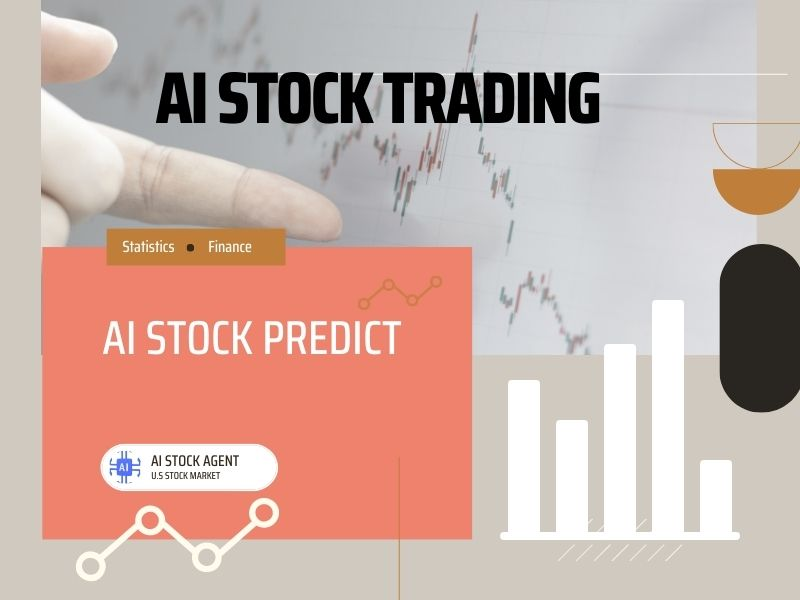
> LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is used for sequence modeling and prediction. The key idea behind LSTM is to address the vanishing gradient problem in RNNs, which occurs when the gradients become very small during backpropagation, making it difficult for the model to learn long-term dependencies in the data.

> The arhitecture of LSTM is called a memory cell which allows the network to ostore and retrieve info over long periods of time. The memory cell is controlled by three gates: input gate, forget gate, and output gate.





> *   Input gate: Input Info + previous hidden state -> sigmoid function -> decision: add to the memory cell / Not add

> *   Forget gate: Input Info + previous hidden state -> sigmoid function -> decision: Decide which parts of the memory cell to keep and which parts to discard

> *   Output gate: Input Info + previous hidden state -> sigmoid function + hyperbolic tangent function -> product final output






> In this search, I will be using LSTM model since it shares the benefits below:



> 1.  **Ability to capture long-term dependencies**: ARIMA can only capture short-term dependencies in the data, while LSTM can capture long-term dependencies. This is important in stock prediction, where past prices and trends can influence future prices over longer periods of time.

> 2.   **Non-linear relationships**: LSTM can capture non-linear relationships in the data, while ARIMA assumes a linear relationship between variables. This is important in stock prediction since stock prices can exhibit complex and non-linear patterns.

> 3. **Handling of missing data**: LSTM can handle missing data, while ARIMA requires a complete dataset. This is important in stock prediction, where missing data can be common due to holidays, weekends, and other factors.

> 4. **Flexibility:** LSTM is a more flexible model than ARIMA, as it can handle multiple inputs and outputs, and can be trained on various types of data such as textual data, technical indicators, and sentiment analysis.










# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# **Import Dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_path = '/content/drive/MyDrive/AI_Projects/kaggleAPI/stock.csv'
data = pd.read_csv(csv_path)

In [ ]:
summary = data.describe()
print(summary)

              Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean     28.426479    28.766532    28.066558    28.412726  2.158391e+07
std      13.257242    13.356692    13.157326    13.258163  1.926231e+07
min       9.100000     9.480000     8.940000     8.950000  1.939061e+06
25%      16.175000    16.385000    15.970000    16.130000  1.248025e+07
50%      27.180000    27.490000    26.820000    27.100000  1.732130e+07
75%      36.655000    37.035000    36.305000    36.635000  2.512757e+07
max      73.020000    73.250000    72.460000    72.930000  4.382317e+08


In [ ]:
data = pd.read_csv(csv_path,parse_dates = ['Date'])
print(data)

           Date   Open   High    Low  Close    Volume  Name
0    2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1    2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2    2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3    2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4    2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
...         ...    ...    ...    ...    ...       ...   ...
3014 2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
3015 2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
3016 2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
3017 2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
3018 2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA

[3019 rows x 7 columns]


**Data Preprocessing :**




Implement MinMaxScaler from sklearn to preprocess the stock dataset, 'close' column.



Why do we use MinMaxScaler?

> It can rescale the features to a fixed range, and in this case, we want (-1,1)

Why do we scale the data to the range(-1,1) instead of (0,1)?

> It allows negative values, which are necessary to represent the decrease in stock prices.













In [ ]:
from sklearn.preprocessing import MinMaxScaler

Closing_Price = data[['Close']].copy()  # Make a copy of the dataframe
scaler = MinMaxScaler(feature_range=(-1, 1))
Closing_Price.loc[:, 'Close'] = scaler.fit_transform(Closing_Price[['Close']])


Split the data into Train and Test sets by defining a sliding window technique. Defining the window widht of the analysis so that we can use the prior time steps to predict the next time step.

In [ ]:
def split_data(stock, sequence_length):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - sequence_length):
        data.append(data_raw[index: index + sequence_length])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]
sequence_length = 30 # choose sequence length
x_train, y_train, x_test, y_test = split_data(Closing_Price, sequence_length)


In [ ]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

Move the data to the GPU

In [ ]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train_lstm = y_train_lstm.to(device)
y_test_lstm = y_test_lstm.to(device)
y_train_gru = y_train_gru.to(device)
y_test_gru = y_test_gru.to(device)


In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out



Move the device in the training loop

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3409605622291565
Epoch  1 MSE:  0.20160718262195587
Epoch  2 MSE:  0.09033135324716568
Epoch  3 MSE:  0.1965620517730713
Epoch  4 MSE:  0.09324881434440613
Epoch  5 MSE:  0.07639434188604355
Epoch  6 MSE:  0.09037569165229797
Epoch  7 MSE:  0.10036054253578186
Epoch  8 MSE:  0.10142677277326584
Epoch  9 MSE:  0.09532492607831955
Epoch  10 MSE:  0.0846736952662468
Epoch  11 MSE:  0.07229746133089066
Epoch  12 MSE:  0.06151431053876877
Epoch  13 MSE:  0.05597798898816109
Epoch  14 MSE:  0.05751951038837433
Epoch  15 MSE:  0.061178792268037796
Epoch  16 MSE:  0.0561075396835804
Epoch  17 MSE:  0.04292616993188858
Epoch  18 MSE:  0.031563714146614075
Epoch  19 MSE:  0.025799870491027832
Epoch  20 MSE:  0.02302686497569084
Epoch  21 MSE:  0.018641741946339607
Epoch  22 MSE:  0.009700421243906021
Epoch  23 MSE:  0.006000640336424112
Epoch  24 MSE:  0.016765601933002472
Epoch  25 MSE:  0.012791566550731659
Epoch  26 MSE:  0.009557983838021755
Epoch  27 MSE:  0.011379132047295

<Figure size 864x432 with 0 Axes>

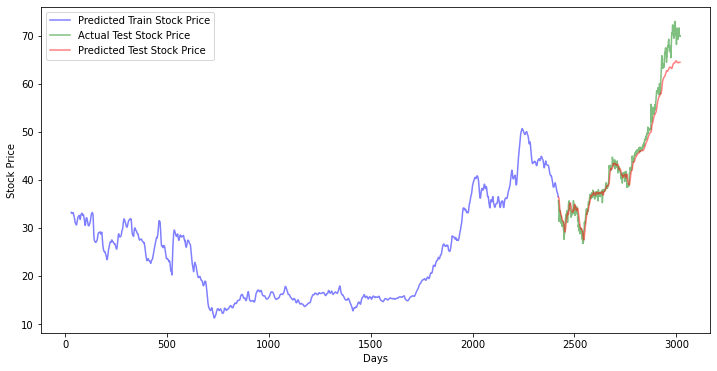

In [ ]:
from sklearn.metrics import mean_absolute_error

# Make predictions for test data
y_test_pred = model(x_test)

# Inverse transform the predicted values to compare with original data
y_train_pred_np = y_train_pred.detach().cpu().numpy()
predicted_train_prices = scaler.inverse_transform(y_train_pred_np)

y_test_pred_np = y_test_pred.detach().cpu().numpy()
predicted_test_prices = scaler.inverse_transform(y_test_pred_np)

# Calculate the Mean Absolute Error for test predictions


# Get the original prices back from the scaled data for the entire dataset
price_back = scaler.inverse_transform(Closing_Price.iloc[sequence_length:].values)

# Get the dates for the x-axis
dates_train = Closing_Price.index[sequence_length:sequence_length+len(x_train)]
dates_test = Closing_Price.index[sequence_length+len(x_train):]

# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot the data
# Plot the data
plt.figure(figsize=(12,6))
# plt.plot(dates_train, price_back[:len(x_train)], label='Actual Train Stock Price', color='red', alpha=0.5)
plt.plot(dates_train, predicted_train_prices, label='Predicted Train Stock Price', color='blue', alpha=0.5)
plt.plot(dates_test, price_back[len(x_train):], label='Actual Test Stock Price', color='green', alpha=0.5)
plt.plot(dates_test, predicted_test_prices, label='Predicted Test Stock Price', color='red', alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


The Mean Absolute Error (MAE) is a metric used to measure the average absolute difference between the predicted valeus and the actual values. In this case, an MAE of 2.20 means that, on averate, the predicted stock prices for the test dataset are off by 2.20 units from the actual stock prices.

If the stock prices are in dollars, an MAE oF 2.20 would mean that, on average, the predictions are off by $2.20 from the actual stock prices in the test dataset

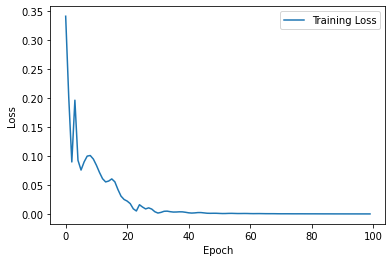

In [ ]:
# Plot the training loss
plt.plot(range(num_epochs), hist, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
